In [1]:
import sys
sys.path.append("../../")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.test_functions.multi_objective import GMM, BraninCurrin
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning

tkwargs = {
    "dtype": torch.double,
#     "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "device": torch.device("cpu"),
}

In [3]:
# define problem
problem = GMM(negate=True).to(**tkwargs)
problem.ref_point = torch.tensor([0., 0.], **tkwargs)
# problem = BraninCurrin(negate=True).to(**tkwargs)

In [4]:
def plot_objective(problem, num_samples: int = 200):
    num_dim = problem.bounds.shape[-1]
    num_obj = problem.ref_point.shape[-1]

    fig = plt.figure(figsize=(5 * (num_dim + 1), 5))

    # only plot the first two dimensions
    xx, yy = np.meshgrid(
        np.linspace(
            *problem.bounds.cpu().t()[0], num_samples
        ),
        np.linspace(
            *problem.bounds.cpu().t()[1], num_samples
        ),
    )
    input_data = np.vstack((xx.flatten(), yy.flatten())).T
    input_data = torch.from_numpy(input_data)
    z = problem(input_data.to(**tkwargs)).cpu()
    pareto = is_non_dominated(z).cpu()
    pareto_set = z.cpu().numpy().copy()
    pareto_set[~pareto] = np.nan

    for i in range(num_dim):
        ax = plt.subplot2grid((1, num_dim + 1), (0, i))
        div = make_axes_locatable(ax)
        cax = div.append_axes('right', '5%', '5%')

        # plot functions
        countourset = ax.contourf(
            xx,
            yy,
            z[:, i].reshape(xx.shape),
        )

        # plot pareto set mask
        ax.scatter(*input_data[pareto].t(), color='tab:red', s=10, label='pareto set')

        cax.grid(False)  # just to remove the warning
        clb = fig.colorbar(countourset, cax=cax)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f"objective {i+1}")
        ax.legend()
        clb.ax.set_title('z')

    ax_pareto = plt.subplot2grid((1, num_dim + 1), (0, num_dim))
    idx = np.argsort(pareto_set[:, 0])
    ax_pareto.plot(*pareto_set[idx].T, color='tab:red', label='approximated pareto front')
    ax_pareto.scatter(*pareto_set[idx].T, color='tab:red', s=10)
    ax_pareto.scatter(*problem.ref_point.cpu().t(), color='tab:red', marker='x', label='refence point')
    ax_pareto.set_title("pareto front")
    ax_pareto.legend()
    plt.tight_layout()

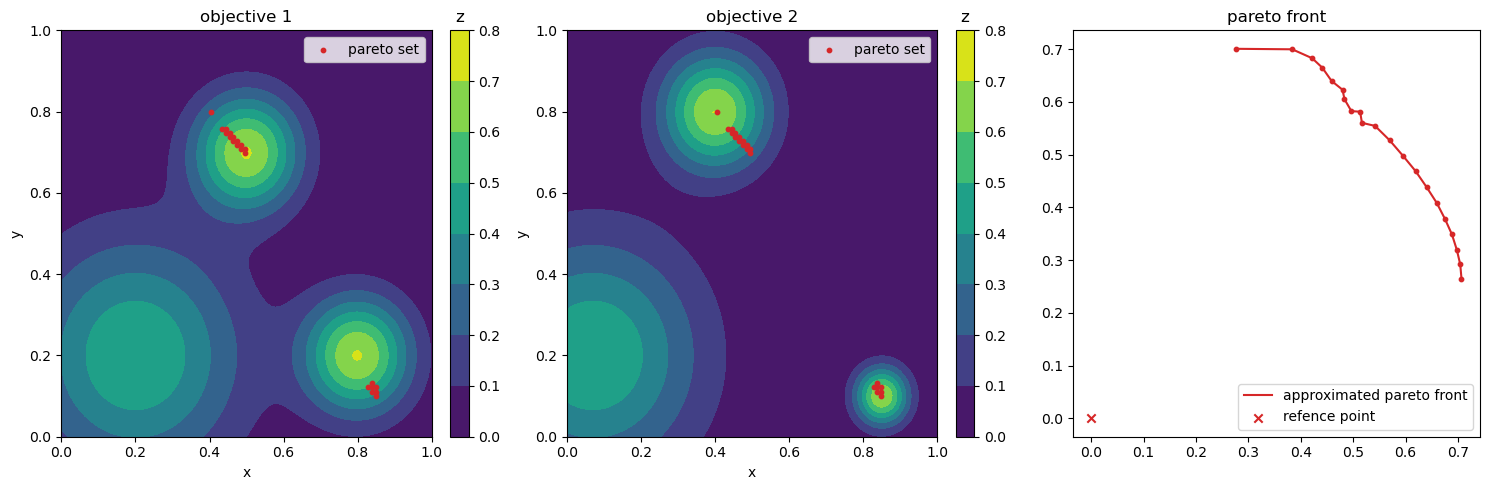

In [5]:
plot_objective(problem, num_samples=100)

In [6]:
def generate_initial_data(problem, n=6):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds, n=n, q=1).squeeze(1)
    train_obj = problem(train_x)
    return train_x, train_obj

In [7]:
init_x, init_y = generate_initial_data(problem, n=6)

## Generate data

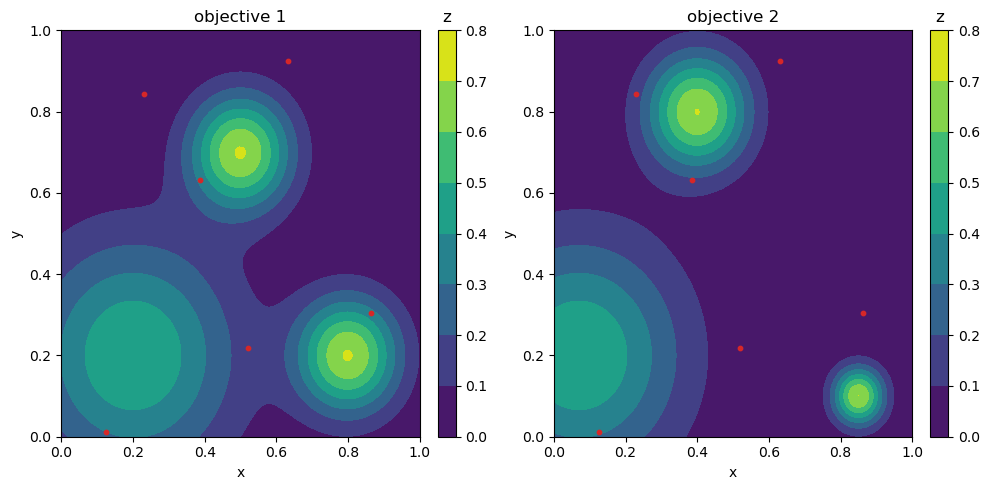

In [8]:
num_dim = problem.bounds.shape[-1]
# only plot the first two dimensions
xx, yy = np.meshgrid(
    np.linspace(
        *problem.bounds.cpu().t()[0], 200
    ),
    np.linspace(
        *problem.bounds.cpu().t()[1], 200
    ),
)
input_data = np.vstack((xx.flatten(), yy.flatten())).T
input_data = torch.from_numpy(input_data).to(**tkwargs)
z = problem(input_data.to(**tkwargs))

fig = plt.figure(figsize=(5 * (num_dim), 5))
for i in range(num_dim):
    ax = plt.subplot2grid((1, num_dim), (0, i))
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')

    # plot functions
    countourset = ax.contourf(
        xx,
        yy,
        z[:, i].cpu().reshape(xx.shape),
    )

    # plot observations
    ax.scatter(*init_x.cpu().t(), s=10, color='tab:red')

    cax.grid(False)  # just to remove the warning
    clb = fig.colorbar(countourset, cax=cax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f"objective {i+1}")
    clb.ax.set_title('z')
plt.tight_layout()

In [9]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [10]:
import pygmo as pg

def get_partial_observations(y_obs, gamma, tkwargs):
    ndf, _, _, _ = pg.core.fast_non_dominated_sorting(-y_obs.numpy())
    print(f"Number of pareto shell {len(ndf)}")

    num_obs = 0
    for n, shell in enumerate(ndf, start=1):
        num_obs += len(shell)
        if num_obs / len(y_obs) > gamma:
            break
    shell_idx = n

    y_shell = torch.empty(0, y_obs.shape[-1], **tkwargs)
    for i in range(shell_idx, len(ndf), 1):
        y_shell = torch.cat((y_shell, y_obs[ndf[i].astype(int)]))

    return y_shell

In [11]:
import math
from collections import OrderedDict

class JointMLP(torch.nn.Module):

    def __init__(
        self,
        input_dim,
        output_dim,
        num_units=64,
        num_layers=3,
        dropout=0.1
    ):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout = torch.nn.Dropout(p=dropout)
        self.num_layers = num_layers
        self.activation = torch.nn.ELU()

        layers = []
        layers.append((f"input_layer", torch.nn.Linear(input_dim, num_units)))
        layers.append((f"activation", self.activation))
        layers.append((f"dropout", self.dropout))
        for i in range(num_layers - 1):
            layers.append((f"layer_{i}", torch.nn.Linear(num_units, num_units)))
            layers.append((f"activation_{i}", self.activation))
            layers.append((f"dropout_{i}", self.dropout))
        layers.append((f"output_layer", torch.nn.Linear(num_units, output_dim)))

        self.model = torch.nn.Sequential(OrderedDict(layers))
        
    def forward(self, x, gamma):
        input = torch.concat([x, gamma], dim=-1)
        features = self.model[0](input)
        for i in range(1, len(self.model) - 2):
            if isinstance(self.model[i], torch.nn.Linear):
                identity = features
                features = self.model[i](features)
                features += identity
            else:
                features = self.model[i](features)
        logits = self.model[-1](features)
        return logits


class LFBO_JointRand:

    def __init__(
        self,
        input_dim,
        output_dim,
        num_units=64,
        num_layers=4,
        weight_type='ei',
        interpolation='lower',
        device="cpu:0",
        dtype=torch.double,
    ):
        self.tkwargs = {"device": device, "dtype": dtype}
        self.clf = JointMLP(
            input_dim=input_dim + 1, # plus 1 for gamma
            output_dim=output_dim,
            num_units=num_units,
            num_layers=num_layers,
        )
        self.clf.to(**self.tkwargs)
        self.weight_type = weight_type
        self.interpolation = interpolation

    @staticmethod
    def split_good_bad(X, y, gamma, weight_type, interpolation):
        tau = torch.quantile(torch.unique(y), q=gamma, interpolation=interpolation)
        z = torch.less(y, tau)
        x_p = X[z.squeeze(), :]
        x_q = X[~z.squeeze(), :]
        x_m = draw_sobol_samples(bounds=problem.bounds, n=int(len(z)/2), q=1).squeeze(1)

        z_p = torch.empty(x_p.shape[0], dtype=torch.long).fill_(0)
        z_q = torch.empty(x_q.shape[0], dtype=torch.long).fill_(1)
        z_m = torch.empty(x_m.shape[0], dtype=torch.long).fill_(2)

        x = torch.cat((x_p, x_q, x_m), dim=0)
        z = torch.cat((z_p, z_q, z_m), dim=0)  
        z = torch.nn.functional.one_hot(z)

        w = torch.tensor([len(x_p), len(x_q), len(x_m)], **tkwargs) / len(x)
        return x, z, w 

    def fit(
        self,
        X_obs,
        y_obs,
        batch_size=64,
        S=100
    ):
        optimizer = torch.optim.Adam(self.clf.parameters())
        # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
        # loss_fn = torch.nn.functional.binary_cross_entropy_with_logits
        loss_fn = torch.nn.CrossEntropyLoss()

        N = len(X_obs)  # N-th iteration
        M = math.ceil(N / batch_size)  # Steps per epochs
        E = math.floor(S / M)

        self.clf.train()
        for epochs in range(E):
            gamma = torch.rand(1, **self.tkwargs)
            new_X, new_z, new_w = self.split_good_bad(
                X_obs.detach(), y_obs.detach(), gamma=gamma, weight_type=self.weight_type, interpolation=self.interpolation
            )
            new_quantile = torch.tensor([[gamma]] * len(new_X), **self.tkwargs)

            # add batch dimension
            train_tensors = [new_X.unsqueeze(1), new_z.to(**self.tkwargs), new_quantile.unsqueeze(1)]
            train_dataset = torch.utils.data.TensorDataset(*train_tensors)
            train_dataloader = torch.utils.data.DataLoader(
                train_dataset,
                batch_size=batch_size,
                shuffle=True
            )

            for _, (inputs, targets, quantile) in enumerate(train_dataloader):
                optimizer.zero_grad(set_to_none=True)

                outputs = self.clf(inputs, quantile)
                batch_loss = loss_fn(
                    outputs.squeeze(1), targets
                )
                batch_loss.backward()
                optimizer.step()
            # scheduler.step()
        self.clf.eval()

    def predict(self, X, gamma):
        quantile = torch.tensor([gamma] * X.shape[0], **self.tkwargs)

        # add batch dimension
        if len(quantile.shape) == 1:
            quantile = quantile[..., None, None]

        with torch.no_grad():
            return self.clf(X.unsqueeze(1), quantile)

In [12]:
from botorch.utils.transforms import unnormalize, normalize


class MOLFBO:
    def __init__(self, problem, device="cpu", dtype=torch.double):
        self.problem = problem
        self.tkwargs = {"dtype": dtype, "device": device}
        self.standard_bounds = torch.zeros(2, problem.dim, **self.tkwargs)
        self.standard_bounds[1] = 1
        self.n_candidates = 40000
        self.warm_start = True

        self.clf_list = [
            LFBO_JointRand(input_dim=problem.bounds.shape[-1], output_dim=3, weight_type='pi', **self.tkwargs)
            for _ in range(problem.num_objectives)
        ]

    def fit_model(self, X_obs, y_obs, S):
        for i, clf in enumerate(self.clf_list):
            clf.fit(X_obs=X_obs, y_obs=y_obs[:, i:i+1], S=S)

    def observe_and_suggest(self, X_obs, y_obs, X_pen=None, batch_size=1, *args, **kwargs):
        # normalize training input
        X_obs_norm = normalize(X_obs, self.problem.bounds)
        
        y_shell = get_partial_observations(y_obs, gamma=0.1, tkwargs=self.tkwargs)

        # they assumes maximization
        bd_shell = DominatedPartitioning(ref_point=self.problem.ref_point, Y=y_shell)
        nbd_shell = FastNondominatedPartitioning(ref_point=self.problem.ref_point, Y=y_shell)
        _, pareto_shell = bd_shell.hypercell_bounds
        ndom_shell, _ = nbd_shell.hypercell_bounds
        
        bd = DominatedPartitioning(ref_point=self.problem.ref_point, Y=y_obs)
        nbd = FastNondominatedPartitioning(ref_point=self.problem.ref_point, Y=y_obs)
        u_pareto, pareto = bd.hypercell_bounds
        ndom, _ = nbd.hypercell_bounds
        x_cands = input_data

        # negate to turn into minimization problem
        y_obs = -y_obs
        u_pareto = -u_pareto
        pareto = -pareto
        ndom = -ndom

        if self.warm_start:
            self.warm_start = False
            S = 1000
        else:
            S = 100

        self.fit_model(X_obs_norm, y_obs, S=S)
        # x_cands = draw_sobol_samples(bounds=self.standard_bounds, n=1, q=self.n_candidates).squeeze(0)
        # u: upper non-dominated point
        # l: lower dominated point
        ref_pts = torch.concat((-ndom_shell, -pareto_shell), dim=0)
        pi_per_region = torch.empty((0, self.n_candidates, 1), **self.tkwargs)
        for ref in ref_pts:
            preds = torch.empty((0, self.n_candidates, 1), **self.tkwargs)
            for i, clf in enumerate(self.clf_list):
                gamma = ((y_obs[:, i:i+1] <= ref[i]).sum() / len(y_obs)).to(**self.tkwargs)

                with torch.no_grad():
                    logits = clf.predict(x_cands, gamma=gamma)
                    class_prob = torch.nn.functional.softmax(logits, dim=-1)
                    preds = torch.concat([preds, (class_prob[:, :, 0]+class_prob[:, :, 2]).unsqueeze(0)], dim=0)

            agg_preds = torch.cumprod(preds, dim=0)[-1]
            pi_per_region = torch.concat((pi_per_region, agg_preds.unsqueeze(0)), dim=0)

        # the number pareto points is always one less than the non-dominated points
        pi_per_region = torch.concat((pi_per_region, torch.zeros_like(pi_per_region[0]).unsqueeze(0)), dim=0)
        pi_per_interval = pi_per_region[:len(ndom_shell)] - pi_per_region[len(ndom_shell):]
        pi = torch.sum(pi_per_interval, dim=0)
        # pi = torch.sum(pi_per_region, dim=0)
        candidates = x_cands[pi.argmax()].unsqueeze(0)
        new_x = unnormalize(candidates.detach(), bounds=self.problem.bounds)

        fig = plt.figure(figsize=(8, 4))

        y_obs = -y_obs
        u_pareto = -u_pareto
        pareto = -pareto
        ndom = -ndom

        # plot aggregated results
        ax_agg = plt.subplot2grid((1, 2), (0, 0))
        div = make_axes_locatable(ax_agg)
        cax = div.append_axes('right', '5%', '5%')
        countourset = ax_agg.contourf(
            xx,
            yy,
            pi.cpu().reshape(xx.shape),
        )
        cax.grid(False)  # just to remove the warning
        clb = fig.colorbar(countourset, cax=cax)
        ax_agg.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')
        ax_agg.scatter(*X_obs.t(), color='tab:red', alpha=0.2)

        ax_agg.set_xlabel('x1')
        ax_agg.set_ylabel('x2')
        ax_agg.set_title(f"aggregated results")
        clb.ax.set_title('z')

        # plot pareto results
        ax_pareto = plt.subplot2grid((1, 2), (0, 1))
        is_pareto = is_non_dominated(y_obs)
        ax_pareto.scatter(*y_obs[~is_pareto].cpu().t(), s=10, alpha=0.3)

        ax_pareto.scatter(*pareto.cpu().t(), s=10, color='tab:red', label="pareto")
        ax_pareto.plot(*pareto.cpu().t(), color='tab:red')

        boxes = [Rectangle(
            l_point.cpu(),
            *(u_point - l_point).cpu(),
        ) for l_point, u_point in zip(pareto, u_pareto)]
        pc = PatchCollection(boxes, cmap='tab10', alpha=.3)
        pc.set_array(torch.arange(0, len(pareto)))
        ax_pareto.add_collection(pc)

        ax_pareto.scatter(*self.problem.ref_point.cpu().t(), color='k', s=10, label="ref point")
        ax_pareto.scatter(*pareto_shell.t(), color='purple', s=10, label="shell")
        # ax_pareto.scatter(*ndom.cpu().t(), s=10, label="non dominated", color='tab:purple')
        new_y = self.problem(new_x) 
        ax_pareto.scatter(*new_y.cpu().t(), marker='x', color='tab:orange', label="candidates")

        ax_pareto.set_xlabel('y1')
        ax_pareto.set_ylabel('y2')
        ax_pareto.set_xlim(self.problem.ref_point[0].item())
        ax_pareto.set_ylim(self.problem.ref_point[1].item())
        ax_pareto.set_title('pareto')
        ax_pareto.legend()
        
        plt.tight_layout()
        plt.show()
        return new_x

Number of pareto shell 3


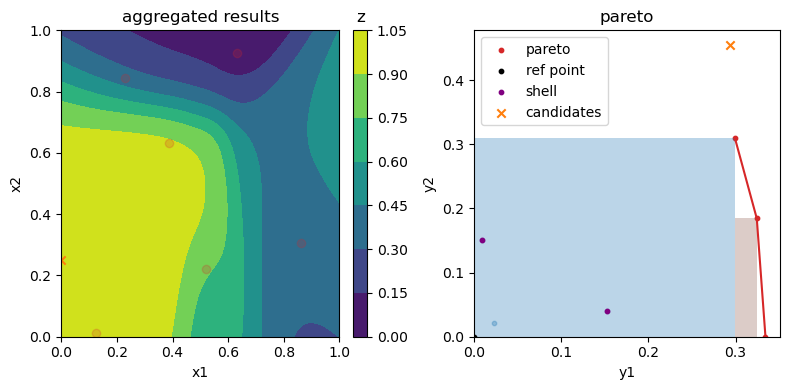

Number of pareto shell 3


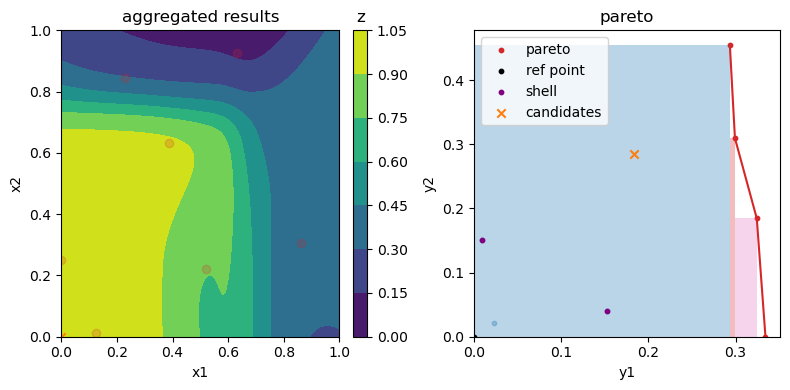

Number of pareto shell 4


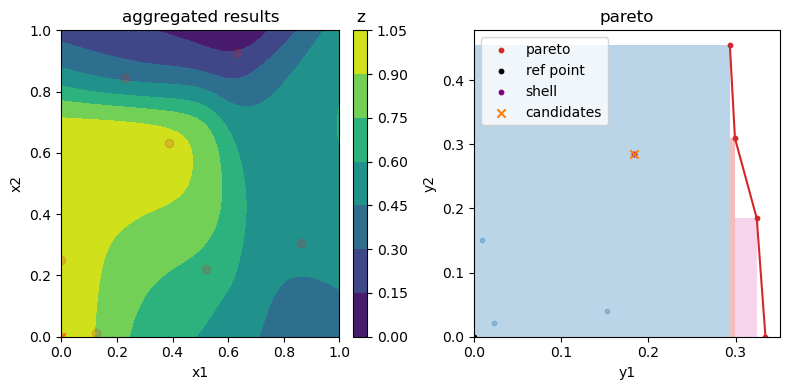

Number of pareto shell 4


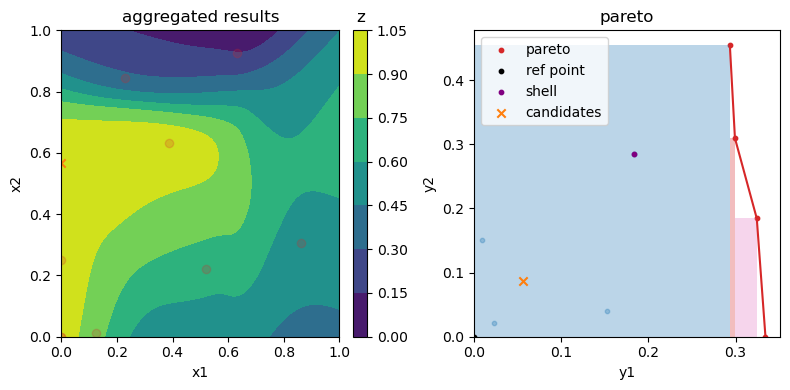

Number of pareto shell 4


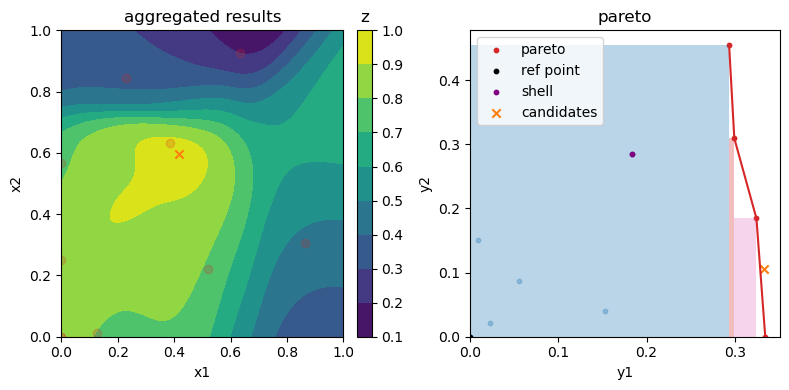

Number of pareto shell 4


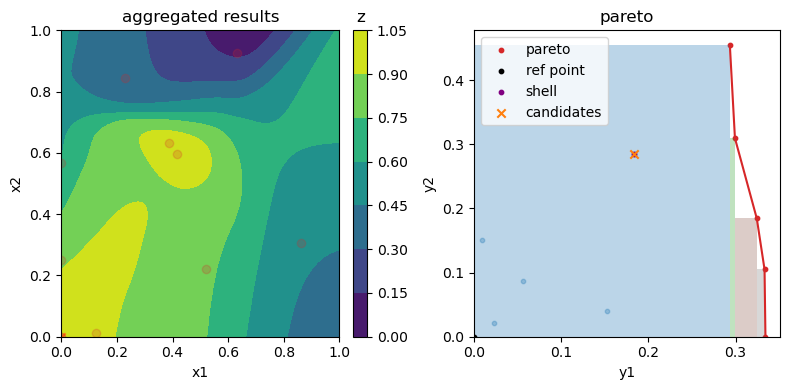

Number of pareto shell 4


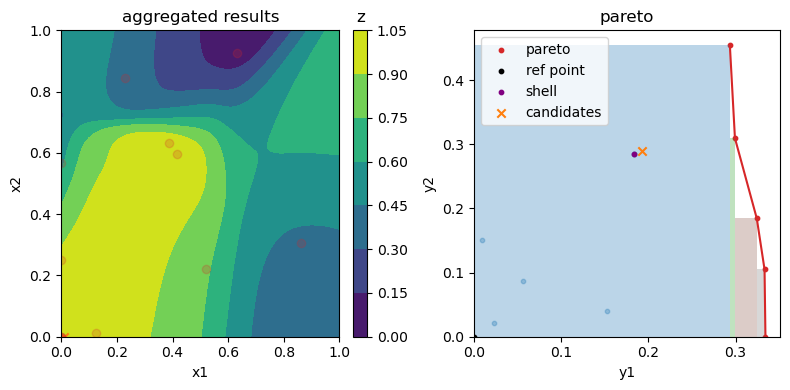

Number of pareto shell 5


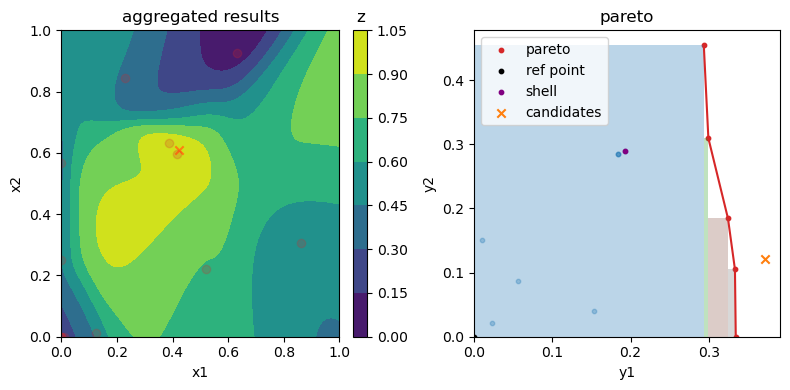

Number of pareto shell 5


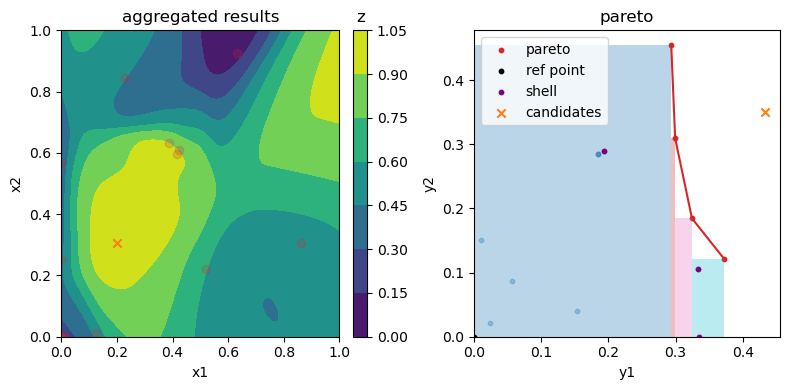

Number of pareto shell 6


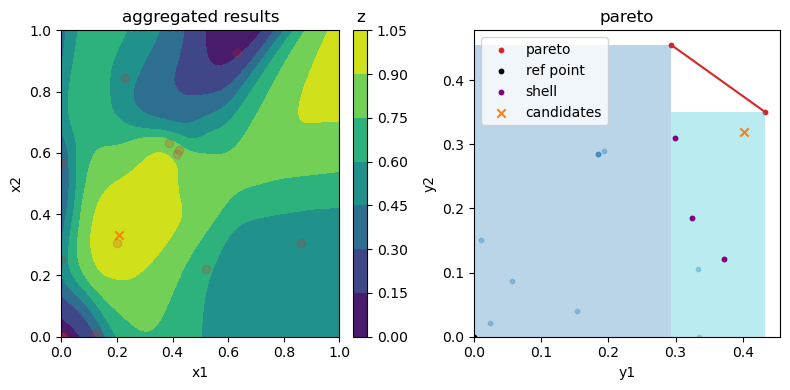

Number of pareto shell 7


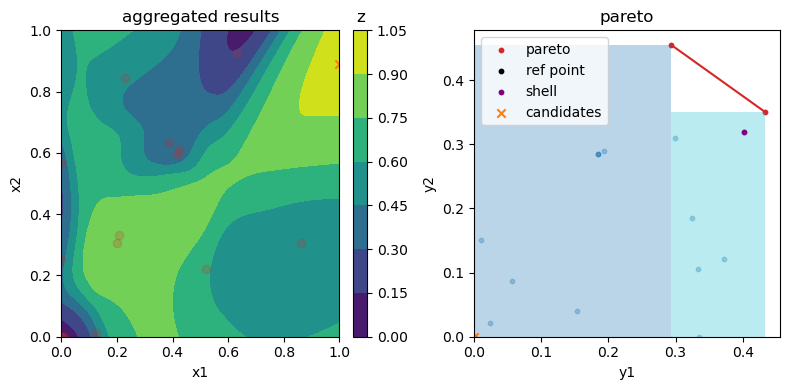

Number of pareto shell 8


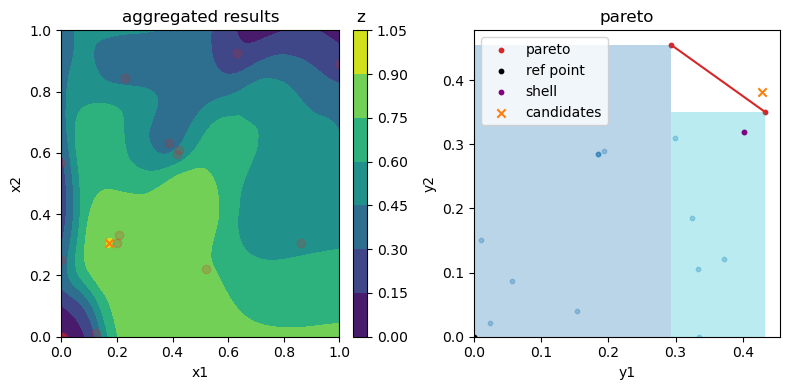

Number of pareto shell 8


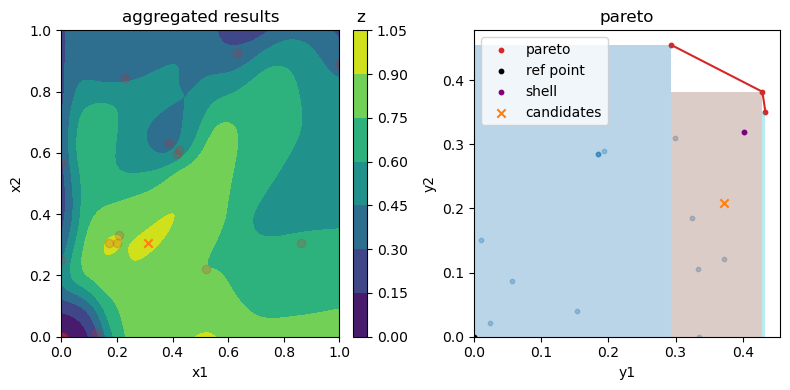

Number of pareto shell 8


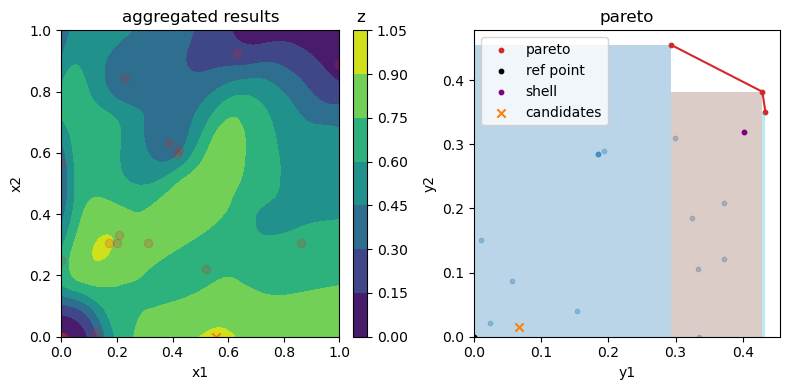

Number of pareto shell 8


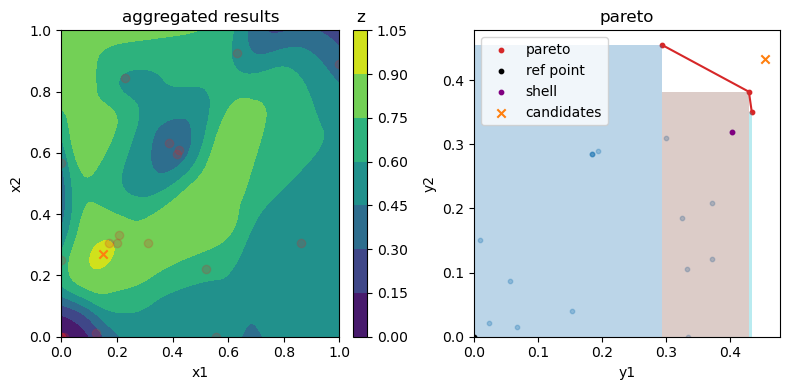

Number of pareto shell 9


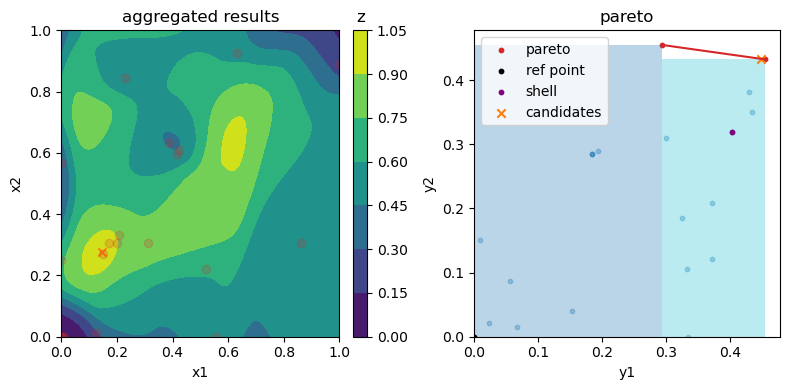

Number of pareto shell 9


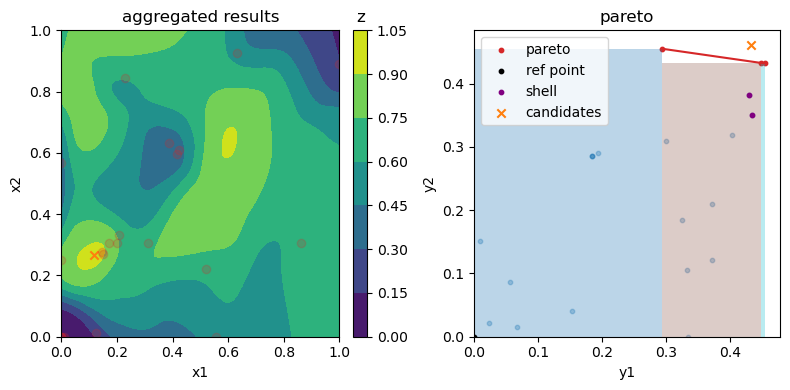

Number of pareto shell 9


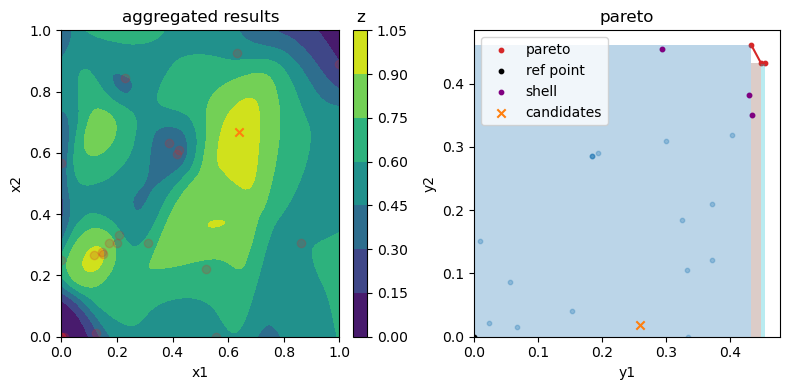

Number of pareto shell 9


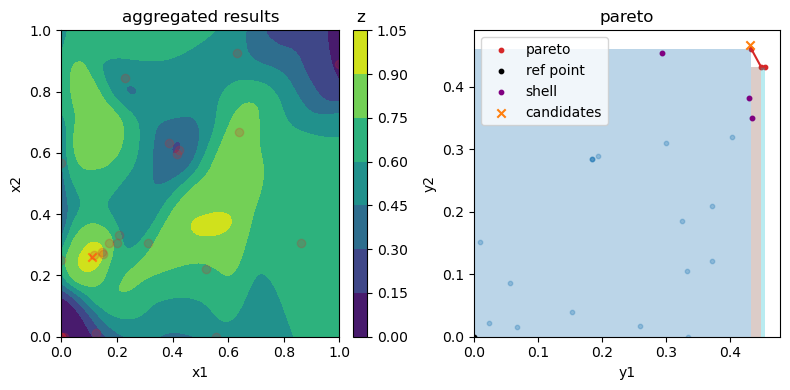

Number of pareto shell 9


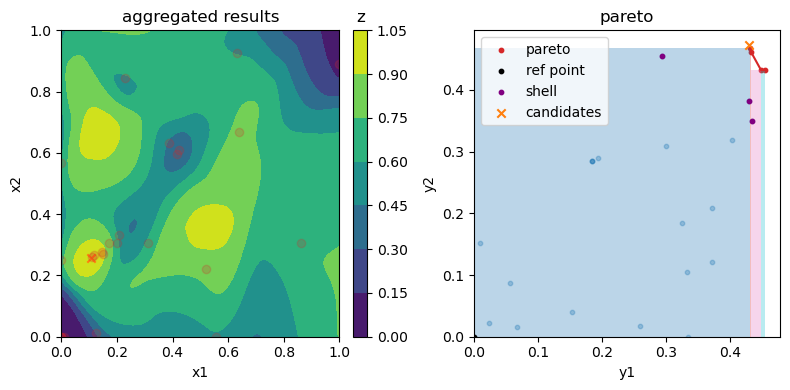

In [13]:
x_obs = init_x
y_obs = init_y

optimizer = MOLFBO(problem)

for _ in range(20):
    new_x = optimizer.observe_and_suggest(x_obs, y_obs)
    new_y = problem(new_x) 
    x_obs = torch.cat([x_obs, new_x])
    y_obs = torch.cat([y_obs, new_y])